In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta 
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, Date, cast

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=True)   #echo=True
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
print(Base.classes.keys())
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

2019-01-25 09:44:29,268 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-01-25 09:44:29,269 INFO sqlalchemy.engine.base.Engine ()
2019-01-25 09:44:29,271 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-01-25 09:44:29,271 INFO sqlalchemy.engine.base.Engine ()
2019-01-25 09:44:29,272 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-01-25 09:44:29,273 INFO sqlalchemy.engine.base.Engine ()
2019-01-25 09:44:29,275 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("measurement")
2019-01-25 09:44:29,277 INFO sqlalchemy.engine.base.Engine ()
2019-01-25 09:44:29,278 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'measurement' AND type = 'table'
2019-01-25 09:44:29,279 INFO sqlalchemy.engine.base.Engine ()
2019-01-25 09:44:29,280 INFO sqlalchemy.

# Exploratory Climate Analysis

In [3]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

2019-01-25 09:44:30,263 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("measurement")
2019-01-25 09:44:30,263 INFO sqlalchemy.engine.base.Engine ()
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [4]:
#inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

2019-01-25 09:44:31,106 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("station")
2019-01-25 09:44:31,107 INFO sqlalchemy.engine.base.Engine ()
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lastDateQ=session.query(Measurement).order_by(desc('date')).limit(1).all()[0]
lastDate = dt.datetime.strptime(lastDateQ.date, "%Y-%m-%d").date()
firstDate= lastDate - timedelta(days=365)
firstDateStr=firstDate.strftime('%Y-%m-%d') 
# Perform a query to retrieve the data and precipitation scores
selectDates = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > firstDateStr)

2019-01-25 09:44:31,874 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2019-01-25 09:44:31,875 INFO sqlalchemy.engine.base.Engine SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2019-01-25 09:44:31,876 INFO sqlalchemy.engine.base.Engine (1, 0)


2019-01-25 09:44:32,581 INFO sqlalchemy.engine.base.Engine SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date > ?
2019-01-25 09:44:32,581 INFO sqlalchemy.engine.base.Engine ('2016-08-23',)


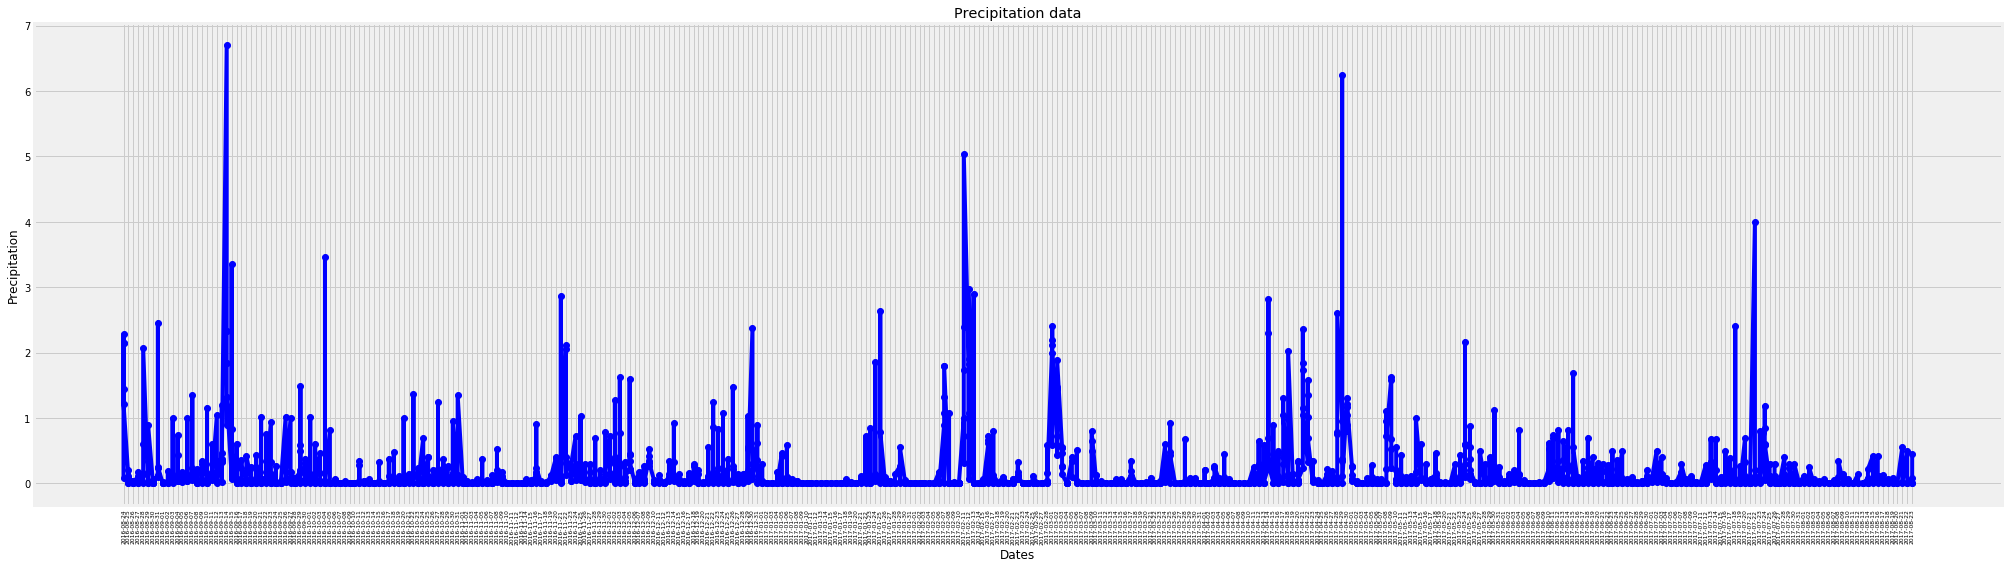

In [6]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(selectDates[:], columns=['date', 'precipitation'])

sdf=df.sort_values(by=['date'])
sdf.dropna(inplace=True) 
allDates=pd.Series(sdf.date)    
allVals=pd.Series(sdf.precipitation)

fig, ax = plt.subplots(figsize=(28, 8))
ax.plot(allDates,allVals,'b-o')
ax.set_xlabel("Dates")
ax.set_ylabel("Precipitation")
plt.xticks(rotation=90,fontsize=6)
ax.set_title("Precipitation data")
fig.tight_layout()
plt.savefig("precipitation.png")
plt.show()


In [7]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sdf.describe()  # ( There's a difference in count beacuse of dropped NaNs )

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [8]:
# Design a query to show how many stations are available in this dataset?
stationsQ=session.query(Measurement).group_by(Measurement.station).count()
print(str(stationsQ)+' stations')

2019-01-25 09:44:43,088 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement GROUP BY measurement.station) AS anon_1
2019-01-25 09:44:43,089 INFO sqlalchemy.engine.base.Engine ()
9 stations


In [9]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activeStationsQ=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

for ast in activeStationsQ:
    print(ast)
    

2019-01-25 09:44:51,470 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC
2019-01-25 09:44:51,471 INFO sqlalchemy.engine.base.Engine ()
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [10]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActive=activeStationsQ[0][0] 
stationxQ=session.query(func.max(Measurement.tobs).label("max_temp"),
                        func.min(Measurement.tobs).label("min_temp"), 
                        func.sum(Measurement.tobs).label("sum"),
                        func.count(Measurement.tobs).label("count")).\
filter(Measurement.station==mostActive) 

print(f'Station {mostActive} -> Max temp: {stationxQ[0].max_temp}, Min Temp:{stationxQ[0].min_temp}, Avergae Temp:{int(stationxQ[0].sum)/int(stationxQ[0].count)}' )

    

2019-01-25 09:45:00,594 INFO sqlalchemy.engine.base.Engine SELECT max(measurement.tobs) AS max_temp, min(measurement.tobs) AS min_temp, sum(measurement.tobs) AS sum, count(measurement.tobs) AS count 
FROM measurement 
WHERE measurement.station = ?
 LIMIT ? OFFSET ?
2019-01-25 09:45:00,595 INFO sqlalchemy.engine.base.Engine ('USC00519281', 1, 0)
2019-01-25 09:45:00,598 INFO sqlalchemy.engine.base.Engine SELECT max(measurement.tobs) AS max_temp, min(measurement.tobs) AS min_temp, sum(measurement.tobs) AS sum, count(measurement.tobs) AS count 
FROM measurement 
WHERE measurement.station = ?
 LIMIT ? OFFSET ?
2019-01-25 09:45:00,599 INFO sqlalchemy.engine.base.Engine ('USC00519281', 1, 0)
2019-01-25 09:45:00,602 INFO sqlalchemy.engine.base.Engine SELECT max(measurement.tobs) AS max_temp, min(measurement.tobs) AS min_temp, sum(measurement.tobs) AS sum, count(measurement.tobs) AS count 
FROM measurement 
WHERE measurement.station = ?
 LIMIT ? OFFSET ?
2019-01-25 09:45:00,603 INFO sqlalchemy.

In [11]:
 firstDateStr #:  one year from last date of data
    #selectDatesxQ=session.query(Measurement.station, Measurement.date, Measurement.tobs)

'2016-08-23'

2019-01-25 09:45:10,663 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date > ? AND measurement.station = ?
2019-01-25 09:45:10,665 INFO sqlalchemy.engine.base.Engine ('2016-08-23', 'USC00519281')


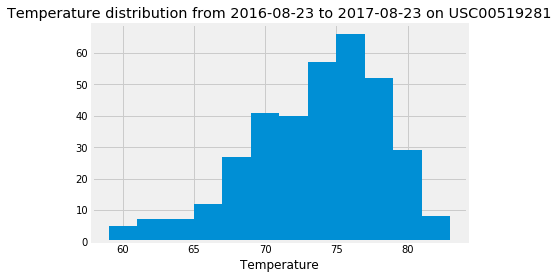

In [12]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
'''
 Design a query to retrieve the last 12 months of temperature observation data (tobs).
  * Filter by the station with the highest number of observations.
  * Plot the results as a histogram with `bins=12`.
'''

#using most active station and one year back date from above


highestTemps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.date > firstDateStr).\
filter(Measurement.station==mostActive)


temps=[]
for l in highestTemps: 
    temps.append(l.tobs)

#plot histogram
#pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)[source]¶
plt.hist(temps, bins=12)
plt.xlabel("Temperature")
plt.title("Temperature distribution from "+firstDateStr +" to "+lastDate.strftime('%Y-%m-%d') +" on "+mostActive)
fig.tight_layout()
plt.savefig("tempHist.png")
plt.show()



In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
"""TMIN, TAVG, and TMAX for a list of dates. 
Args:
    start_date (string): A date string in the format %Y-%m-%d
    end_date (string): A date string in the format %Y-%m-%d   
Returns:
    TMIN, TAVE, and TMAX
"""

def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

2019-01-25 09:45:15,522 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2019-01-25 09:45:15,523 INFO sqlalchemy.engine.base.Engine ('2012-02-28', '2012-03-05')
[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. <--- unclear dates
tripStartDate='2011-02-28'
tripEndDate='2011-03-05'
tripTemps=calc_temps(tripStartDate,tripEndDate) 
print(f'For range {tripStartDate} to {tripEndDate} min Temp:{tripTemps[0][0]} average Temp:{tripTemps[0][1]} max Temp:{tripTemps[0][2]} ')

2019-01-25 09:45:20,661 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2019-01-25 09:45:20,663 INFO sqlalchemy.engine.base.Engine ('2011-02-28', '2011-03-05')
For range 2011-02-28 to 2011-03-05 min Temp:61.0 average Temp:69.75510204081633 max Temp:75.0 


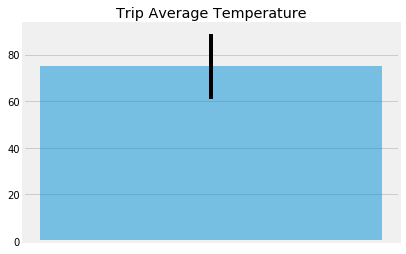

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr) 

#pyplot.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)[source]
#xerr, yerr : scalar or array-like of shape(N,) or shape(2,N), optional

plt.bar(tripTemps[0][1], tripTemps[0][2], yerr=tripTemps[0][2]-tripTemps[0][0] , align='center', alpha=0.5)
plt.title('Trip Average Temperature')
plt.xticks([])
plt.savefig("avgTemp.png")
plt.show()


In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.

#-- assmung total rainfall for selected dates
rainfallpsinfoQ=session.query(func.sum(Measurement.prcp).label("tPrecip"), Measurement.station, 
                              Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station==Station.station).\
        filter(Measurement.date >= tripStartDate).filter(Measurement.date <= tripEndDate).\
        group_by(Measurement.station).order_by(desc('tPrecip')).all()

rows=len(rainfallpsinfoQ)                                                                                                
#cols=len(rainfallpsinfoQ[0])

for list in rainfallpsinfoQ: 
    for x in list: 
        print(x)


2019-01-25 10:32:11,559 INFO sqlalchemy.engine.base.Engine SELECT sum(measurement.prcp) AS "tPrecip", measurement.station AS measurement_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM measurement, station 
WHERE measurement.station = station.station AND measurement.date >= ? AND measurement.date <= ? GROUP BY measurement.station ORDER BY "tPrecip" DESC
2019-01-25 10:32:11,561 INFO sqlalchemy.engine.base.Engine ('2011-02-28', '2011-03-05')
2.33
USC00518838
UPPER WAHIAWA 874.3, HI US
21.4992
-158.0111
306.6
2.23
USC00519281
WAIHEE 837.5, HI US
21.45167
-157.84888999999998
32.9
2.19
USC00519523
WAIMANALO EXPERIMENTAL FARM, HI US
21.33556
-157.71139
19.5
1.96
USC00514830
KUALOA RANCH HEADQUARTERS 886.9, HI US
21.5213
-157.8374
7.0
1.45
USC00516128
MANOA LYON ARBO 785.2, HI US
21.3331
-157.8025
152.4
1.44
USC00513117
KANEOHE 838.1, HI US
21.4234
-157.8015
14.6
1.38
USC00519397


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
#-- assmung total rainfall for selected dates

rainfallpsQ=session.query(func.sum(Measurement.prcp).label("precip"), Measurement.station).\
        filter(Measurement.date >= tripStartDate).filter(Measurement.date <= tripEndDate).\
        group_by(Measurement.station).all()

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfallpsinfoQ=session.query(func.sum(Measurement.prcp).label("tPrecip"), Measurement.station, 
                              Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station==Station.station).\
        filter(Measurement.date >= tripStartDate).filter(Measurement.date <= tripEndDate).\
        group_by(Measurement.station).order_by(desc('tPrecip')).all()

for record in rainfallpsinfoQ: 
    (measurement, station) = record
    print(measurement.station, measurement.tPrecip, station.name, station)
    

2019-01-25 10:15:32,012 INFO sqlalchemy.engine.base.Engine SELECT sum(measurement.prcp) AS precip, measurement.station AS measurement_station 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ? GROUP BY measurement.station
2019-01-25 10:15:32,013 INFO sqlalchemy.engine.base.Engine ('2011-02-28', '2011-03-05')


NameError: name 'rainfallspQ' is not defined

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
